In [1]:
# Import dependencies
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Create sqlalchemy
from sqlalchemy import create_engine
engine = create_engine(f"sqlite:///spotify.sqlite")

In [3]:
# Connect to database
with engine.connect() as conn:
    songsdf = pd.read_sql("SELECT * FROM songs", conn)

In [4]:
songsdf.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,hit,genre
0,000CzNKC8PEt1yC3L8dqwV,0.249,0.518,0.805,0.000000,0.3330,-6.248,0.0407,79.124,0.8410,0.0,Cinema
1,000DfZJww8KiixTKuk9usJ,0.366,0.631,0.513,0.000004,0.1090,-6.376,0.0293,120.365,0.3070,0.0,Ska_Reggae
2,000EWWBkYaREzsBplYjUag,0.815,0.768,0.137,0.922000,0.1130,-13.284,0.0747,76.430,0.5600,0.0,Jazz_Blues
3,000xQL6tZNLJzIrtIgxqSl,0.131,0.748,0.627,0.000000,0.0852,-6.029,0.0644,120.963,0.5240,1.0,Danceclub
4,001bQcMKt86oNbnWne4EAB,0.231,0.747,0.583,0.000000,0.0443,-7.072,0.0575,114.071,0.0381,0.0,World


In [5]:
# One-hot encoding of genre
# Create the OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit the encoder and produce encoded DataFrame
encode_df = pd.DataFrame(enc.fit_transform(songsdf.genre.values.reshape(-1,1)))

# Rename encoded columns
encode_df.columns = enc.get_feature_names(['genre'])
encode_df.head()

,genre_Childrens,genre_Cinema,genre_Classical,genre_Danceclub,genre_Folk_Country,genre_Hip_Hop_R&B,genre_Indie,genre_Jazz_Blues,genre_Pop,genre_Rock,genre_Ska_Reggae,genre_World
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [6]:
# Merge the dataframes and drop genre
songsdf2 = songsdf.merge(encode_df, left_index=True, right_index=True).drop("genre",1)


In [7]:
songsdf2.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,...,genre_Classical,genre_Danceclub,genre_Folk_Country,genre_Hip_Hop_R&B,genre_Indie,genre_Jazz_Blues,genre_Pop,genre_Rock,genre_Ska_Reggae,genre_World
0,000CzNKC8PEt1yC3L8dqwV,0.249,0.518,0.805,0.000000,0.3330,-6.248,0.0407,79.124,0.8410,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,000DfZJww8KiixTKuk9usJ,0.366,0.631,0.513,0.000004,0.1090,-6.376,0.0293,120.365,0.3070,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,000EWWBkYaREzsBplYjUag,0.815,0.768,0.137,0.922000,0.1130,-13.284,0.0747,76.430,0.5600,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,000xQL6tZNLJzIrtIgxqSl,0.131,0.748,0.627,0.000000,0.0852,-6.029,0.0644,120.963,0.5240,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,001bQcMKt86oNbnWne4EAB,0.231,0.747,0.583,0.000000,0.0443,-7.072,0.0575,114.071,0.0381,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
# Scale tempo and loudness

scaled_features = songsdf2.copy()
col_names = ['loudness', 'tempo']
features = scaled_features[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

scaled_features[col_names] = features
scaled_features.head()

# Export scaler model to joblib
joblib.dump(scaler, './scaler_model.joblib')

['./scaler_model.joblib']

In [9]:
# Correlation matrix
matrix = scaled_features.corr().round(2)
print(matrix)

                    acousticness  danceability  energy  instrumentalness  \
acousticness                1.00         -0.43   -0.80              0.35   
danceability               -0.43          1.00    0.42             -0.38   
energy                     -0.80          0.42    1.00             -0.39   
instrumentalness            0.35         -0.38   -0.39              1.00   
liveness                   -0.09         -0.04    0.18             -0.12   
loudness                   -0.71          0.51    0.84             -0.52   
speechiness                -0.13          0.25    0.15             -0.18   
tempo                      -0.23          0.07    0.26             -0.14   
valence                    -0.36          0.60    0.50             -0.35   
hit                        -0.21          0.22    0.17             -0.21   
genre_Childrens             0.10          0.15   -0.10             -0.02   
genre_Cinema                0.30         -0.31   -0.31              0.31   
genre_Classi

<AxesSubplot:>

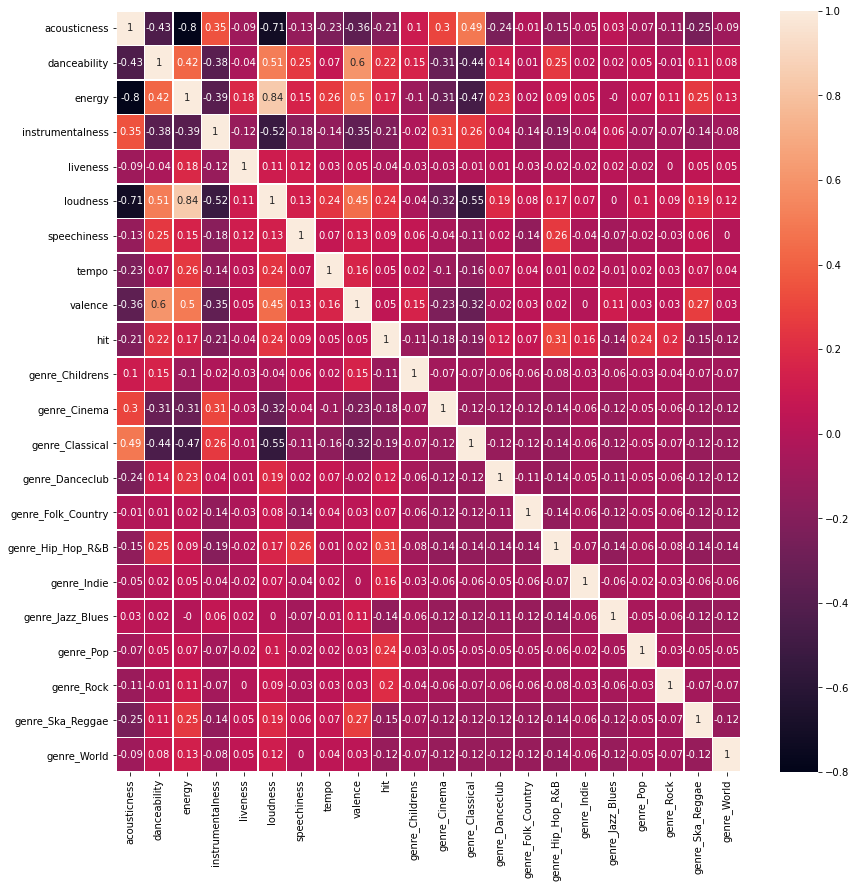

In [10]:
# correlation matrix heatmap
# sns.heatmap(matrix, annot=True)
# plt.rcParams['figure.figsize'] = [8, 8]
# plt.show()
fig, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(matrix, annot=True, linewidths=.5, ax=ax)

In [11]:
# Separate the features from the target
y = scaled_features['hit']
X = scaled_features.drop(columns= ['hit', 'track_id'])

In [12]:
# Split data into testing and training
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)
X_train.shape

(115152, 21)

In [13]:
# Creating logistic regression model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs',
                               max_iter=100,
                               random_state=1)

In [14]:
# fit model using training data
classifier.fit(X_train, y_train)

C:\Users\chees\anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(random_state=1)

In [15]:
# Make predictions
y_pred = classifier.predict(X_test)
results = pd.DataFrame({'Prediction': y_pred, 'Actual': y_test}).reset_index(drop=True)
results.head(20)

,Prediction,Actual
0,1.0,1.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0
6,0.0,0.0
7,0.0,1.0
8,0.0,0.0
9,1.0,1.0


In [16]:
# Get accuracy score
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.8187833789240588


In [17]:
# Confusion matrix for logistic regression
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

[[25708  2821]
 [ 4135  5721]]


In [18]:
# Classification report for logistic regression
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88     28529
         1.0       0.67      0.58      0.62      9856

    accuracy                           0.82     38385
   macro avg       0.77      0.74      0.75     38385
weighted avg       0.81      0.82      0.81     38385



In [19]:
# Model 2 - Random Forest
# Create RF classifier
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=128, random_state=1)

In [20]:
# fit the model
rf_model = rf_model.fit(X_train, y_train)

In [21]:
# Make predictions
predictions = rf_model.predict(X_test)

In [22]:
# Calculating the confusion matrix.
cm = confusion_matrix(y_test, predictions)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

,Predicted 0,Predicted 1
Actual 0,26326,2203
Actual 1,3918,5938


In [23]:
# Classification report for random forest
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

         0.0       0.87      0.92      0.90     28529
         1.0       0.73      0.60      0.66      9856

    accuracy                           0.84     38385
   macro avg       0.80      0.76      0.78     38385
weighted avg       0.83      0.84      0.84     38385



In [24]:
# Display sorted list of features and their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.08759091270621323, 'loudness'),
 (0.08144162904946617, 'acousticness'),
 (0.08115048472372578, 'danceability'),
 (0.07807808985469437, 'energy'),
 (0.07734971323621768, 'speechiness'),
 (0.07470039859901649, 'instrumentalness'),
 (0.07251421054175897, 'valence'),
 (0.07093101544369461, 'tempo'),
 (0.06920717685442747, 'genre_Hip_Hop_R&B'),
 (0.06847920916242366, 'liveness'),
 (0.052836236560170176, 'genre_Pop'),
 (0.03537719445075899, 'genre_Rock'),
 (0.026214335667904768, 'genre_Indie'),
 (0.02111913801449676, 'genre_Ska_Reggae'),
 (0.02097500791247112, 'genre_Danceclub'),
 (0.017436576974786754, 'genre_Folk_Country'),
 (0.016697658812676132, 'genre_Jazz_Blues'),
 (0.016171294360637526, 'genre_World'),
 (0.01403178741380311, 'genre_Cinema'),
 (0.009771492532381519, 'genre_Childrens'),
 (0.00792643712827483, 'genre_Classical')]

In [25]:
# Export random forest model to joblib
joblib.dump(rf_model, './random_forest.joblib', compress=3)

['./random_forest.joblib']